In [1]:
# Initializing colab for using kaggle
! pip install -q kaggle

from google.colab import files

# Uploading kaggle.json file
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Importing anaconda-python data from kaggle
!kaggle datasets download -d pvaddina/pythons-vs-anacondas

  0% 0.00/5.57M [00:00<?, ?B/s]
100% 5.57M/5.57M [00:00<00:00, 51.5MB/s]


In [3]:
# unzipping downloaded pythons-vs-anacondas.zip file
from zipfile import ZipFile
filename = "pythons-vs-anacondas.zip"

with ZipFile(filename, 'r') as zip:
    zip.extractall()
    print("Done")

Done


In [4]:
# Importing required modules

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
print(tf.__version__)

2.3.0


In [5]:
# Loading inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-10-30 18:30:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.7.208, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   177MB/s    in 0.5s    

2020-10-30 18:30:19 (177 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                            include_top=False,
                            weights=None)

pre_trained_model.load_weights(local_weights_file)

# freezing the top layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer("mixed10")
print(pre_trained_model.output_shape)
last_layer = pre_trained_model.output

(None, 3, 3, 2048)


In [19]:
# Deploying our deep neural network
x = keras.layers.Flatten()(last_layer)
x = keras.layers.Dense(1024, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

# compiling out model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [20]:
# intializing callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>=0.9) and (logs.get('val_accuracy')>=0.9):
            print("\nAccuracy and validation accuracy is high so cancelling training")
            self.model.stop_training = True

In [21]:
# Using ImageDataGenerator for data augmentation
train_dir = "anacondas_pythons/train"
test_dir = "anacondas_pythons/valid"

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.3)

test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    class_mode='binary',
                                                    batch_size=1)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=1,
                                                class_mode='binary')

Found 60 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [22]:
# Making call for callback
callbacks = myCallback()

# training model and using callback
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=30,
                              steps_per_epoch=13,
                              validation_steps=20,
                              callbacks = [callbacks],
                              verbose=2)

Epoch 1/30
13/13 - 2s - loss: 100.4376 - accuracy: 0.4615 - val_loss: 14.3508 - val_accuracy: 0.6000
Epoch 2/30
13/13 - 1s - loss: 18.7900 - accuracy: 0.7692 - val_loss: 14.7131 - val_accuracy: 0.6500
Epoch 3/30
13/13 - 1s - loss: 32.3176 - accuracy: 0.7692 - val_loss: 13.1228 - val_accuracy: 0.7000
Epoch 4/30
13/13 - 0s - loss: 33.2837 - accuracy: 0.6923 - val_loss: 9.3288 - val_accuracy: 0.8000
Epoch 5/30
13/13 - 1s - loss: 14.2389 - accuracy: 0.7692 - val_loss: 44.2400 - val_accuracy: 0.5500
Epoch 6/30
13/13 - 1s - loss: 17.9092 - accuracy: 0.6923 - val_loss: 19.7598 - val_accuracy: 0.7000
Epoch 7/30
13/13 - 0s - loss: 21.7718 - accuracy: 0.6923 - val_loss: 7.0792 - val_accuracy: 0.9000
Epoch 8/30

Accuracy and validation accuracy is high so cancelling training
13/13 - 0s - loss: 6.6794e-29 - accuracy: 1.0000 - val_loss: 3.2175 - val_accuracy: 0.9500


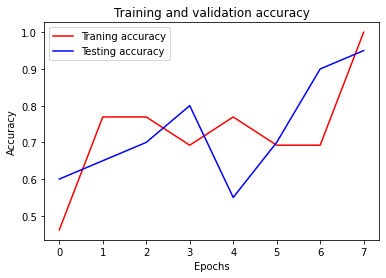

<Figure size 432x288 with 0 Axes>

In [23]:
# Plotting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Traning accuracy')
plt.plot(epochs,val_acc,'b',label='Testing accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()